In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
arc = load('mnist.npz')

x_train = arc['arr_0']
y_train = arc['arr_1']
x_test  = arc['arr_2']
y_test  = arc['arr_3']

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


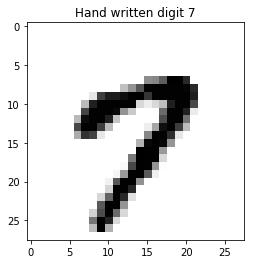

In [4]:
# Show image number 15, and write in the title what digit it should correspond to
N=15
imshow(x_train[N], cmap='gray_r')
_ = title('Hand written digit '+str(y_train[N]))

# Assignment 1

Implement the following distance functions

- d_infty $$ d_{\infty}(a,b) := \max_{i,j} |b_{ij}-a_{ij}|$$
- d_one $$ d_1(a,b) := \sum_{i,j} |b_{ij}-a_{ij}|$$
- d_two $$ d_2(a,b) := \sqrt{\sum_{i,j} |b_{ij}-a_{ij}|^2}$$

that take two `(28,28)` images in input, and return a non-negative number.

In [5]:
def d_infty(a,b):
    return norm(a.ravel()-b.ravel(), inf)

def d_one(a,b):
    return norm(a.ravel()-b.ravel(), 1)

def d_two(a,b):
    return norm(a.ravel()-b.ravel(), 2)

In [35]:
d_infty(x_train[2],x_train[5])

1.0

# Assignment 2

Write a function that, given a number `N`, and a distance function `dist`, computes the distance matrix D of shape `(N,N)` between the first `N` entries of `x_train`:

```
D[i,j] = dist(x_train[i], x_train[j])
```

performing the **minimum** number of operations (i.e., avoid computing a distance if it has already been computed before, i.e., keep in mind that dist(a,b) = dist(b,a)).

In [6]:
def distance_matrix(N,dist):
    D = zeros((N,N))
    for i in range(N):
        for j in range(i+1):
            D[i,j] = D[j,i] = dist(x_train[i],x_train[j])
    return D

In [51]:
distance_matrix(5,d_one)

array([[  0.        , 115.70979309, 148.50196838, 122.61177063,
        135.43136597],
       [115.70979309,   0.        , 160.91764832, 141.45881653,
        134.8666687 ],
       [148.50196838, 160.91764832,   0.        , 125.60784149,
        127.84706116],
       [122.61177063, 141.45881653, 125.60784149,   0.        ,
        107.94117737],
       [135.43136597, 134.8666687 , 127.84706116, 107.94117737,
          0.        ]])

# Assignment 3

Compute and plot the three distance matrices

- Dinfty
- D1
- D2

for the first 100 images of the training set, using the function `imshow` applied to the three matrices

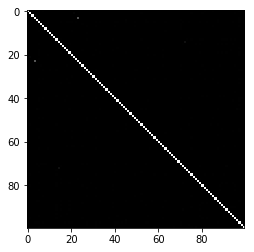

In [54]:
imshow(distance_matrix(100,d_infty), cmap='gray_r')

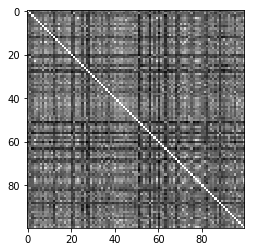

In [55]:
imshow(distance_matrix(100,d_one), cmap='gray_r')

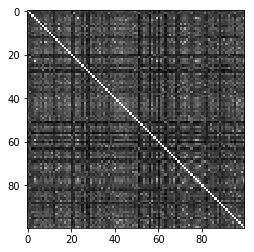

In [58]:
imshow(distance_matrix(100,d_two), cmap='gray_r')

# Assignment 4

Using only a distance matrix, apply the algorithm described above and compute the efficency of the algorithm, i.e., write a function that:

Given a distance matrix with shape `(N,N)`, constructed on the first `N` samples of the `x_train` set, count the number of failures of the **leave one out** strategy, i.e., 

- set `error_counter` to zero

- for every line `i` of the matrix:

    - find the index `j` (different from `i`) for which `D[i,k] >= D[i,j]` for all `k` different from `i` and `j`.

    - if `y_train[j]` is different from `y_train[i]`, increment by one `error_counter`

- return the error: error_counter/N

- apply the function above to the 3 different distance matrices you computed before

In [7]:
def performance_evaluator(N,dist):
    D = distance_matrix(N,dist)
    error_counter = 0
    N = len(D)
    for i in range(N):
        l = D[i]
        l[i] = l[0]+42
        closer_one = argmin(l)
        if(y_train[i] != y_train[closer_one]):
            error_counter = error_counter + 1
            
    return error_counter/N

In [90]:
performance_evaluator(1000,d_one)

0.128

# Assignment 5

Run the algorithm implemented above for N=100,200,400,800,1600 on the three different distances, and plot the three error rate as a function of N (i.e., compute the distance matrix, and compute the efficiency associated to the distance matrix).

You should get an error like:
```
[[ 0.58      0.17      0.17    ]
 [ 0.52      0.145     0.135   ]
 [ 0.4425    0.15      0.135   ]
 [ 0.4       0.145     0.12875 ]
 [ 0.369375  0.1025    0.09375 ]]
```
where each column represents a different norm.

In [8]:
sizes = [100,200,400,800,1600]
errors = [[performance_evaluator(n,d_infty),performance_evaluator(n,d_one),performance_evaluator(n,d_two)] for n in sizes]
errors

[[0.58, 0.16, 0.17],
 [0.52, 0.14, 0.135],
 [0.4425, 0.1475, 0.135],
 [0.4, 0.145, 0.12875],
 [0.369375, 0.1025, 0.09375]]

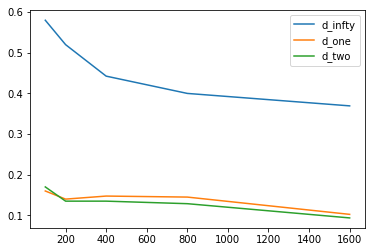

In [134]:
errors = array(errors)
for i in range(len(errors.T)):
    plot(sizes, errors.T[i])
    
_ = legend(['d_infty','d_one','d_two'])

** In the next assignments, optional points are given if you manage to make the algorithm run faster, by pre-computing everything you can precompute in advance **

# Assignment 6

In principle, it should be possible to decrease the error by using a better norm. From the table above, it is clear that the L2 distance works better than the L1 distance, which works better than the Linfty distance.

However, *none of these distances exploit the fact that the image is a two-dimensional object*, and that there is information also in the **neighboring** information of the pixels. 

One way to exploit this, is to interpret the image as a continuous function with values between zero and one, defined on a square domain `\Omega=[0,27]x[0,27]`.

$$ f: \Omega \to R $$

- Implement a function that computes an approximation of the $H^1$ norm distance on the renormalized images. Given two images $f_1$ and $f_2$
    - Compute $$a = \frac{f_1}{\int_\Omega f_1}$$, $$b=\frac{f_2}{\int_\Omega f_2}$$
    - Define the $H^1$ distance as
    $$
    d_{H^1}(f_1,f_2) := \sqrt{\int_\Omega |\nabla(a-b)|^2+ (a-b)^2}
    $$
    using the algorithm you prefer (or the library you prefer) to compute the gradients and the integrals. Notice that $\nabla f = (\partial f/\partial x, \partial f/\partial y)$ is a vector valued function, and $|\nabla g|^2 := (\partial g/\partial x)^2 + (\partial g/\partial y)^2$

- Compute the distance matrix and the efficiency for this distance for N=100,200,400,800,1600


In [50]:
def image_integral(image):
    return sum(image)

def central_differences(v):
    l = len(v)
    x = zeros(l)
    for i in range(1,l-1):
        x[i] = (v[i+1]-v[i-1])*0.5
        
    return x

def image_gradient(image):
    #space = image
    #x_derivative = [central_differences(space[i]) for i in range(len(space))]
    #space = space.T
    #y_derivative = [central_differences(space[i]) for i in range(len(space))]
    #return (array(x_derivative),array(y_derivative))
    return numpy.gradient(image)

def squared_gradient(f):
    gr = image_gradient(f)
    return gr[0]*gr[0] + gr[1]*gr[1]


def d_H1(f1,f2):
    a = f1/image_integral(f1)
    b = f2/image_integral(f2)
    
    diff = a-b
    #c = norm(image_gradient(diff))
    return sqrt(image_integral(squared_gradient(diff) + diff**2))

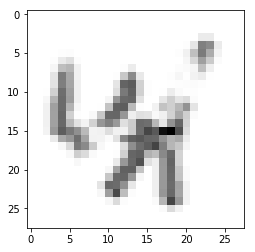

In [95]:
#imshow(distance_matrix(200,d_H1), cmap='gray_r')
#image_gradient(x_train[N])
#squared_gradient(x_train[N])

im1 = x_train[2]
im2 = x_train[9]
diff = im1 - im2

imshow((squared_gradient(diff) + diff**2), cmap='gray_r')

#image_gradient(x_train[12])[0]

In [70]:
performance_evaluator(1600,d_H1)

0.099375

## Assignment 7

An even better improvement on the previous distance function is given by the following algorithm

- Given two images $f1$ and $f2$:
    - Compute $$a = \frac{f_1}{\int_\Omega f_1}$$, $$b=\frac{f_2}{\int_\Omega f_2}$$
    - Solve 
    $$
    -\Delta \phi = a - b \qquad \text{ in } \Omega
    $$
    $$
    \phi = 0 \text{ on } \partial\Omega
    $$
    - Define the *Monge Ampere* distance
    $$
    d_{MA}(f_1,f_2) = \int_\Omega (a+b)|\nabla \phi|^2
    $$

- Compute the distance matrix and the efficiency for this distance for N=100,200,400,800,1600

In [ ]:
def solve_boundary_problem(f):
    pass



def d_MA(f1,f2):
    a = f1/image_integral(f1)
    b = f2/image_integral(f2)
    
    theta = solve_boundary_problem(a-b)
    return image_integral((a+b)*squared_gradient(theta))